In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import re
import os
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt

import nltk
import ssl
try:
     _create_unverified_https_context =     ssl._create_unverified_context
except AttributeError:
     pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
from nltk.corpus import stopwords
import contractions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Layer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
data = pd.read_csv('/content/drive/MyDrive/archive (1)/cnn_dailymail/train.csv')

In [12]:
data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [13]:
data.drop_duplicates(subset=['highlights'],inplace=True)
data.reset_index(inplace=True, drop=True)

In [14]:
data

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...
...,...,...,...
282192,fffdfb56fdf1a12d364562cc2b9b1d4de7481dee,By . James Rush . Former first daughter Chelse...,Chelsea Clinton said question of running for o...
282193,fffeecb8690b85de8c3faed80adbc7a978f9ae2a,An apologetic Vanilla Ice has given his first ...,"Vanilla Ice, 47 - real name Robert Van Winkle ..."
282194,ffff5231e4c71544bc6c97015cdb16c60e42b3f4,America's most lethal sniper claimed he wished...,America's most lethal sniper made comment in i...
282195,ffff924b14a8d82058b6c1c5368ff1113c1632af,"By . Sara Malm . PUBLISHED: . 12:19 EST, 8 Mar...",A swarm of more than one million has crossed b...


In [15]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    text = ' '.join([contractions.fix(word) for word in text.split(" ")])    
    
    tokens = [w for w in text.split() if not w in stop_words]
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [16]:
data['highlights'] = data['highlights'].apply(preprocess)
data['article'] = data['article'].apply(preprocess)
data['highlights'] = data['highlights'].apply(lambda x : '_START_ '+ x + ' _END_')

for i in range(2):
    print('Summary:', data['highlights'][i],'Text:', data['article'][i], sep='\n')
    print()

Summary:
_START_ bishop john folda north dakota taking time diagnosed contracted infection contaminated food italy church members fargo grand forks jamestown could exposed  _END_
Text:
 associated press published 14 11 est 25 october 2013 updated 15 36 est 25 october 2013 bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late september early october state health department issued advisory exposure anyone attended five churches took communion bishop john folda bishop located 

Summary:
_START_ criminal complaint cop used role help cocaine traffickers ralph mata internal affairs lieutenant allegedly helped group get guns also arranged pay two assassins murder plot complaint alleges  _END_
Text:
 decided move forward murder plot mata still received payment setting meetings federal prosecutors said statement complaint also alleges mata used police badge purchase weapons drug traffickers mata according complain

In [17]:
headlines_length = [len(x.split()) for x in data['highlights']]
text_length = [len(x.split()) for x in data['article']]

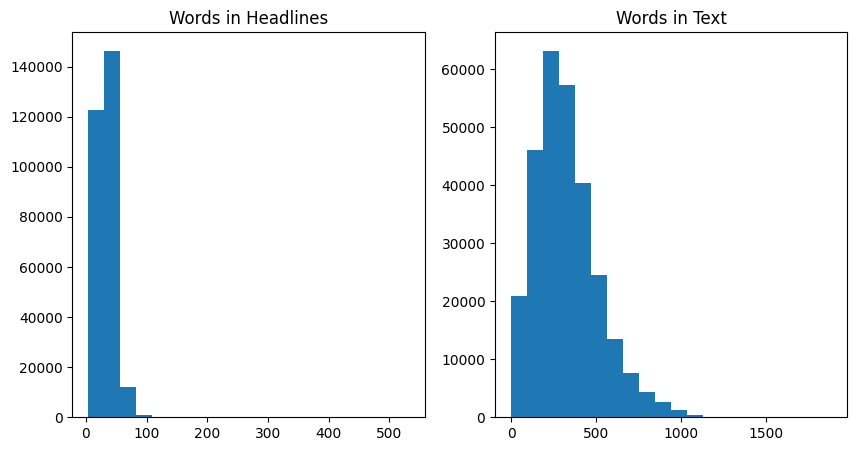

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")
plt.show()

In [19]:
max_length_x = 250
max_length_y = 50
x = []
y = []
for ind in data.index:
    if((len(data.iloc[ind]['article'].split()) <= max_length_x) and (len(data.iloc[ind]['highlights'].split()) <= max_length_y)):
        x.append(data.iloc[ind]['article'])
        y.append(data.iloc[ind]['highlights'])

data = pd.DataFrame(list(zip(x,y)), columns=['article', 'highlights'])
data

,article,highlights
0,associated press published 14 11 est 25 octob...,_START_ bishop john folda north dakota taking ...
1,decided move forward murder plot mata still r...,_START_ criminal complaint cop used role help ...
2,drunk driver killed young woman head on crash ...,_START_ craig eccleston todd 27 drunk least th...
3,accused making many fashion faux pas holiday p...,_START_ prime minister family enjoying easter ...
4,canberra australia campbell unscrews couple bo...,_START_ black box data flight 370 could analyz...
...,...,...
102470,joshua gardner 89 year old washington state s...,_START_ miyo koba moses lake washington threat...
102471,daily mail reporter published 08 25 est 29 ma...,_START_ ban would prohibit visitors wildwood n...
102472,double lung transplant give little girl life ...,_START_ 10 year old sarah murnaghan could die ...
102473,neil ashton follow neilashton marco reus ilka...,_START_ manchester united need decide wayne ro...


In [20]:
glove_size = 300
f = open('/content/drive/MyDrive/Glove/glove.42B.300d.txt')


In [21]:
embeddings_index = dict()
for line in f:
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
f.close()

In [22]:
words_source_train = []
for i in data['article']:
    words_source_train.extend(i.split(' '))

print("all the words in the corpus", len(words_source_train))
words_source_train = set(words_source_train)
print("the unique words in the corpus", len(words_source_train))
inter_words = set(embeddings_index.keys()).intersection(words_source_train)
print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_source_train))
*100)))

words_corpus_source_train = {}
words_glove = set(embeddings_index.keys())
for i in words_source_train:
    if i in words_glove:
        words_corpus_source_train[i] = embeddings_index[i]
print("word 2 vec length", len(words_corpus_source_train))

all the words in the corpus 16110935
the unique words in the corpus 196796
The number of words that are present in both glove vectors and our corpus are 157387 which is nearly 80.0% 
word 2 vec length 157387


In [23]:
print(list(words_source_train - inter_words)[:20])

['', 'ocrates', 'olliegillman', 'andytcarroll', 'harileta', 'octogoat', 'garmely', 'warrenbury', 'panuphol', 'nad9l', 'fabrgeas', 'oghad', 'mohune', 'andreychenko', 'grlsimone', 'unilad', '852am', 'twinston', 'lcdas', 'wwwscottishfacouk']


In [24]:
def num(text):
  words = [w for w in text.split() if not w in inter_words]
  return len(words)

data['unique_words'] = data['article'].apply(num)

In [25]:
data['unique_words'].value_counts()

0     65724
1     19639
2      7911
3      3629
4      2019
5      1256
6       742
7       498
8       342
9       247
10      168
11       99
12       61
13       39
14       29
15       19
16       10
17        8
18        8
20        7
23        4
22        3
19        3
27        3
24        2
31        1
26        1
29        1
50        1
28        1
Name: unique_words, dtype: int64

In [26]:
data = data[data['unique_words'] < 4]
data.reset_index(inplace=True, drop=True)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['article'], data['highlights'], test_size = 0.2, random_state = 20)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.7, random_state = 20)

In [29]:
x_t = Tokenizer()
x_t.fit_on_texts(data['article'] + data['highlights'])
x_vocab_size = len(x_t.word_index) + 1

encoded_xtrain = x_t.texts_to_sequences(X_train)
encoded_xval = x_t.texts_to_sequences(X_val)
encoded_xtest = x_t.texts_to_sequences(X_test)

padded_xtrain = pad_sequences(encoded_xtrain, maxlen=max_length_x, padding='post')
padded_xval = pad_sequences(encoded_xval, maxlen=max_length_x, padding='post')
padded_xtest = pad_sequences(encoded_xtest, maxlen=max_length_x, padding='post')

In [30]:
y_t = Tokenizer()
y_t.fit_on_texts(data['highlights'])
y_vocab_size = len(y_t.word_index) + 1

encoded_ytrain = y_t.texts_to_sequences(y_train)
encoded_yval = y_t.texts_to_sequences(y_val)
encoded_ytest = y_t.texts_to_sequences(y_test)

padded_ytrain = pad_sequences(encoded_ytrain, maxlen=max_length_y, padding='post')
padded_yval = pad_sequences(encoded_yval, maxlen=max_length_y, padding='post')
padded_ytest = pad_sequences(encoded_ytest, maxlen=max_length_y, padding='post')

In [31]:
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((x_vocab_size, glove_size))
for word, i in x_t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 1917494 word vectors.


In [32]:
logger = tf.get_logger()


class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [33]:
latent_dim=500

K.clear_session() 

encoder_inputs = Input(shape=(max_length_x,)) 
enc_emb = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False)(encoder_inputs) 

#LSTM 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 250, 300)     55735500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 250, 500),   1602000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [34]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
checkpoint_filepath = './model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss',mode='min',save_best_only=True, save_freq = "epoch")
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
history=model.fit([padded_xtrain,padded_ytrain[:,:-1]], padded_ytrain.reshape(padded_ytrain.shape[0],padded_ytrain.shape[1], 1)[:,1:] ,epochs=30,batch_size=32, validation_data=([padded_xval,padded_yval[:,:-1]], padded_yval.reshape(padded_yval.shape[0],padded_yval.shape[1], 1)[:,1:]), callbacks=[model_checkpoint_callback], verbose=1)

Epoch 1/30
2423/2423 [==============================] - 727s 293ms/step - loss: 5.0189 - val_loss: 4.6338
Epoch 2/30
2423/2423 [==============================] - 711s 293ms/step - loss: 4.3848 - val_loss: 4.3518
Epoch 3/30
2423/2423 [==============================] - 706s 291ms/step - loss: 3.9825 - val_loss: 4.2752
Epoch 4/30
2423/2423 [==============================] - 704s 291ms/step - loss: 3.6673 - val_loss: 4.2774
Epoch 5/30
2423/2423 [==============================] - 705s 291ms/step - loss: 3.4194 - val_loss: 4.3060
Epoch 6/30
2423/2423 [==============================] - 702s 290ms/step - loss: 3.2416 - val_loss: 4.3309
Epoch 7/30
2423/2423 [==============================] - 701s 290ms/step - loss: 3.1185 - val_loss: 4.3628
Epoch 8/30
2423/2423 [==============================] - 702s 290ms/step - loss: 3.0140 - val_loss: 4.3946
Epoch 9/30
2423/2423 [==============================] - 700s 289ms/step - loss: 2.9290 - val_loss: 4.4213
Epoch 10/30
2423/2423 [=======================

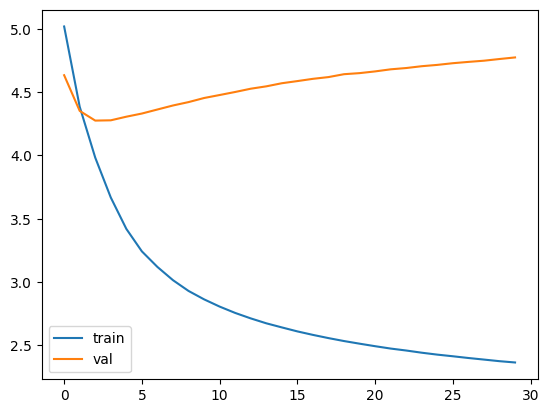

In [35]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='val') 
pyplot.legend() 
pyplot.show()

In [36]:
reverse_target_word_index = y_t.index_word 
reverse_source_word_index = x_t.index_word 
target_word_index = y_t.word_index

In [37]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_x,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [38]:
def decode_sequence(input_seq):
    input_seq= input_seq.reshape(1,max_length_x)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
  
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
 
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_length_y-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

In [39]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [40]:
for i in range(10):
    print("Review:",seq2text(padded_xtest[i]))
    print("Original summary:",seq2summary(padded_ytest[i]))
    print("Predicted summary:",decode_sequence(padded_xtest[i]))
    print("\n")

Review: washington 2 356 fugitive sex offenders service said this might considered cream crop violent felons there example arrested 433 murder suspects said yous marshals director john f clark chicago illinois news conference course operation marshals also confiscated 582 firearms 2 400 kilograms narcotics often find fugitives hiding fruits crimes firearms drugs evidence type criminal activity clark said unregistered sex offenders major target clark said we highlighted one case chicago area involved individual alleged molested 9 year old girl violated parole investigation located said there evidence crimes happened since register sex offender typical type individual there somewhere streets america often harming children others one operation involved cleveland ohio police swat team yous marshals following lead jeremiah jackson 29 wanted murder accused shooting woman back robbery june 9 team surrounded house intelligence surveillance team said jackson might be jackson reported armed dang

In [41]:
def BLEU_Score(y_test, y_pred):
    references = [[seq2summary(y_test).split(" ")]]
    candidates = [decode_sequence(y_pred.reshape(1,max_length_x)).split(" ")]
    return corpus_bleu(references, candidates)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
scores=[]
for i in range(len(padded_ytest)):
    try:
        score = BLEU_Score(padded_ytest[i],padded_xtest[i])
        scores.append(score)
    except:
        pass
print(np.mean(scores))

1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fbe9a4d7250>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


1/1 [==============================] - ETA: 0s